In [7]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.plot_data as plot
import models.transforms as transforms
import algorithms.teaching_algs as algs
import evals.teaching_evals as evals

def get_ci(samples, confidence=0.95):  return stats.sem(samples) * stats.t.ppf((1 + confidence) / 2., len(samples)-1)
def get_random_score(dist_m, m, X, y_train, y_test, n_trials=1000):
    random_scores = np.array([evals.get_knn_score_lpips(dist_m, algs.random(X, m), y_train, y_test) for _ in range(n_trials)])
    random_ci = get_ci(random_scores)
    random_score = random_scores.mean()
    return random_score, random_ci

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
dataset = "bird"
# transform = transforms.shrink((64,64))
transform = transforms.bird_transform()

In [15]:
train = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/train", transform=transform)
test = torchvision.datasets.ImageFolder(f"data/datasets/{dataset}/test", transform=transform)
x_train = np.array([x[0].numpy() for x in train])
x_test = np.array([x[0].numpy() for x in test])
y_train = np.array([x[1] for x in train])
y_test = np.array([x[1] for x in test])
X = np.array([x.flatten() for x in x_train])

lpips_path = f"data/dist/lpips/{dataset}"
lpips_alex = pickle.load(open(f"{lpips_path}/lpips.alex.test.pkl","rb"))
lpips_vgg = pickle.load(open(f"{lpips_path}/lpips.vgg.test.pkl","rb"))
lpips_squeeze = pickle.load(open(f"{lpips_path}/lpips.squeeze.test.pkl","rb"))

In [16]:
m_range = np.arange(3,21)
lw = 4

Text(0.5, 0.98, 'lpips_knn_learner: bird')

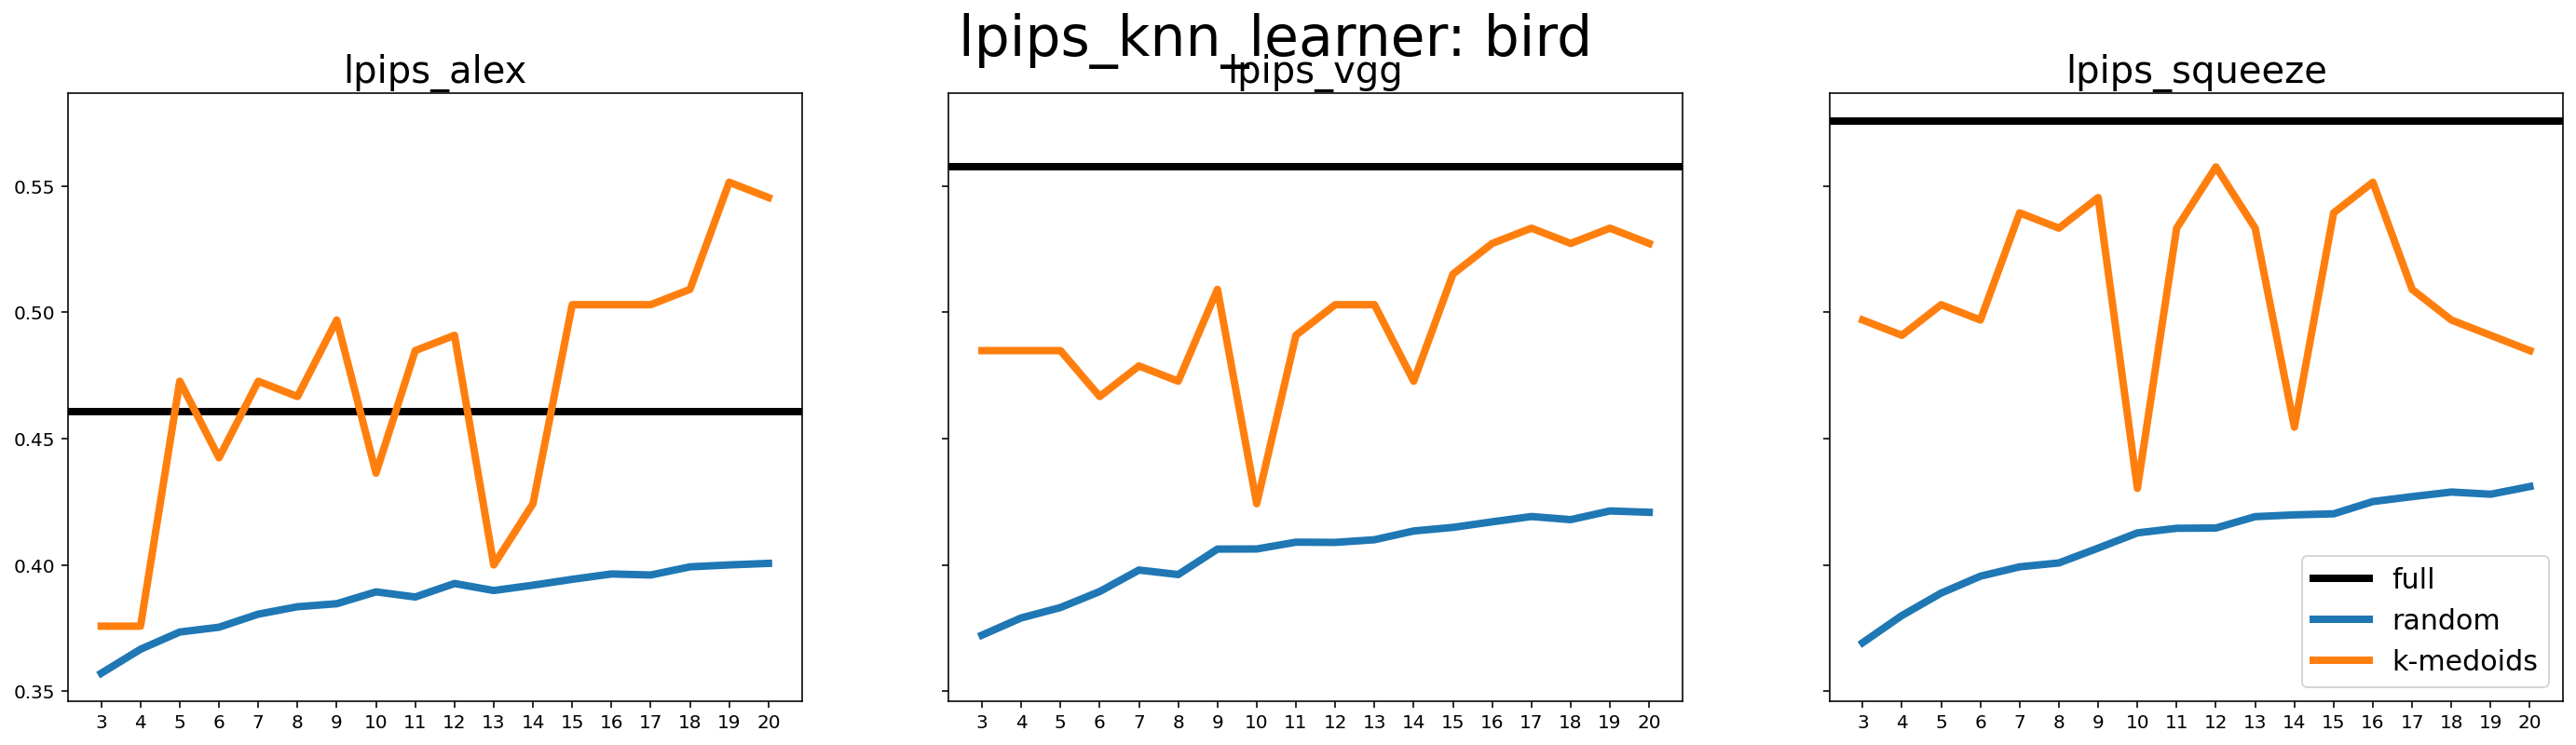

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(24, 6), sharey=True)
for i, (lpips, title) in enumerate([(lpips_alex, "lpips_alex"), (lpips_vgg, "lpips_vgg"), (lpips_squeeze,"lpips_squeeze")]):
    full_score = evals.get_knn_score_lpips(lpips, np.arange(len(y_train)), y_train, y_test, k=1)
    random_scores = []
    random_cis = []
    for m in m_range:
        random_score, random_ci = get_random_score(lpips, m, X, y_train, y_test)
        random_scores.append(random_score)
        random_cis.append(random_ci)
    random_scores = np.array(random_scores)
    random_cis = np.array(random_cis)
    # pdash_scores = [evals.get_knn_score_lpips(lpips, algs.protodash(X, m), y_train, y_test, k=1) for m in m_range]
    k_medoids_scores = [evals.get_knn_score_lpips(lpips, algs.k_medoids(X, m), y_train, y_test, k=1) for m in m_range]

    ax[i].axhline(full_score, lw=lw, c='black')
    ax[i].plot(m_range, random_scores, lw=lw)
    # ax[i].fill_between(m_range, random_scores+random_cis, random_scores-random_cis, alpha=0.5)
    # ax[i].plot(m_range, pdash_scores, lw=lw)
    ax[i].plot(m_range, k_medoids_scores, lw=lw)
    ax[i].set_xticks(m_range, fontsize=20)
    ax[i].set_title(title)

# ax[2].legend(['full', 'random', 'protodash', 'k-medoids'])
ax[2].legend(['full', 'random', 'k-medoids'])
fig.suptitle(f"lpips_knn_learner: {dataset}")